In [3]:
using JLD
using JuMP  
using Ipopt
using Plots
using LaTeXStrings
using LinearAlgebra
using Plots.PlotMeasures

\begin{equation}
    \left\lbrace \begin{array}{lllll}
    &\displaystyle\min_{u(\cdot)\in [0, u_{\max}]} \ \ J(u) 
    \\
    \\
    \text{s.t.}&\\
    &\dot{x}(t) = \big(M(s(t))-u(t)I_n+\varepsilon Z\big)x(t), \\
    \\
       & \dot{s}(t) = - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s(t))x_j(t)}{Y_j}+ u(t)(s_{in}-s(t))
    \end{array}
    \right.
\end{equation}

* Model 1 :

  *  $ J(u):=-\displaystyle\int_0^T P\big(x(t),u(t)\big) \; d t $

  * $  S(x(t)) \ \leq \ \alpha, \quad \forall t\geq 0$

* Model 2 :

  *  $ J(u):=\displaystyle\int_0^T S(x(t)) \; d t $

  * $ P\big(x(t),u(t)\big) \ \geq \ \beta, \quad \forall t\geq 0$



**Parameters:**

In [4]:
n = 5 

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  
Y = ones(n)
s_in = 35.0
x0_def = ones(n)

d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_Z = SymTridiagonal(d, d1);

In [5]:
# import functions of the model
include("functions.jl");

In [6]:
mutable struct incognitas
    t; x; s ; u 
end

**Optimization code:**

In [7]:
function CHEMOSTAT(model=1, params=(0,1,0,0), tf = 30.0, umin=0.0, umax = 5.0, x0 = x0_def, s0 = 1, y0=0, nsteps=150, tol=1e-8, max_iter=600, display=true)
    
    # Constants
    N  = nsteps     # Grid size
    (ε, α, β, γ) = params
    T  = tf
    Δt = T/N

    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys, "linear_solver", "mumps")  
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"acceptable_tol", tol)
    set_optimizer_attribute(sys,"max_iter",max_iter)
    if !display
        set_silent(sys)
    end

    # Include external functions from "functions.jl" file
    register(sys, :μ, 2, μ, autodiff=true)
    register(sys, :M, 4, M, autodiff=true)
    register(sys, :dS, 3, dS, autodiff=true)
    register(sys, :S_func, 1, S_func, autodiff=true)
    register(sys, :P_func, 2, P_func, autodiff=true)

    @variables(sys, begin
                 x[1:n,1:N+1] ≥ 1e-6 #species
                 s[1:N+1] ≥ 0 #substrate
                 B[1:N+1] #biodiversity
                 P[1:N+1] #production
         umin ≤  u[1:N+1] ≤ umax #dilution
    end)

    
    # Boundary constraints
    @constraints(sys, begin
        con_x0,   x[:,1] == x0
        con_s0,   s[1]   == s0 
        con_B0,   B[1]   == y0 
        con_P0,   P[1]   == y0 
    end)

    # Dynamics
    @expression(sys, dx[i = 1:n, j = 1:N+1], ((μ(s[j],i) - u[j]) * x[i,j]) +M(ε,x[:,j],s[j],i) ) #dynamic on x
    @expression(sys, ds[j = 1:N+1], dS(x[:,j],s[j],u[j]) ) #dynamics on s
    @expression(sys, du2[j = 2:N-1], (u[j+1] - u[j])^2 ) #smoothing term on u
    @expression(sys, dP[j = 1:N+1], P_func(u[j],x[:,j]) ) #dynamics on P
    @expression(sys, dB[j = 1:N+1], S_func(x[:,j]) ) #dynamics on B
   
    

    # Dynamics with 2nd order Runge-kutta scheme
    @NLconstraints(sys, begin
        con_dx[i=1:n,j=1:N], x[i,j+1] == x[i,j] +  0.5 * Δt *(dx[i,j+1] + dx[i,j])
        con_ds[j=1:N],         s[j+1] == s[j]  + 0.5 * Δt * (ds[j+1]  +  ds[j])
        con_dP[j=1:N],         P[j+1] == P[j]  + 0.5 * Δt * (dP[j+1]  +  dP[j])
        con_dB[j=1:N],         B[j+1] == B[j]  + 0.5 * Δt * (dB[j+1]  +  dB[j])
    end)       
    
    # Define the inequality constraints and Objetive function
    if model==1
        @NLconstraint(sys, con_B[j=1:N+1], dB[j] <= α ) 
        @NLobjective(sys, Min, -P[N+1]+  γ*sum(du2[j] for j in 2:N-1))
        
    elseif model==2
        @NLconstraint(sys, con_P[j=1:N+1], dP[j] >= β ) 
        @NLobjective(sys, Min, B[N+1]+  γ*sum(du2[j] for j in 2:N-1))
    end


    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys);
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values 
    x  = value.(x)[:,:]
    s  = value.(s)[:]
    # B  = value.(B)[:]
    # P  = value.(P)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
           
    return incognitas(t, x, s , u), termination_status(sys);
    
end;

**Example of solution:**

In [37]:
# Resolution 

model = 1

ε    = 0.01
tf   = 75.0
umin = 1e-4 
umax = 3 
α    = 0.49
γ    = 0.4
β    = 0.0
params = (ε, α, β, γ)

x0     = 5*ones(n)
s0     = s_in-sum(x0)
y0     = 0
nsteps = 200   
tol    = 1e-3
max_iter = 50000
display  = true

sol, status = CHEMOSTAT(model, params, tf, umin, umax,x0, s0, y0, nsteps, tol, max_iter, display);
println(status)

Solving...
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    17208
Number of nonzeros in inequality constraint Jacobian.:     1005
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1809
                     variables with only lower bounds:     1206
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1608
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      201

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.99e+00 1.80e+00   0.0 0.00e+00    -  0.00e+0

**Plotting of the solution:**

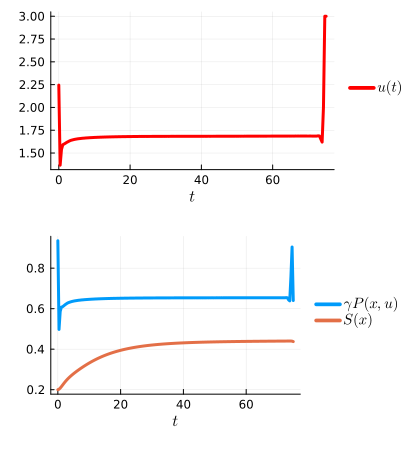

In [38]:
t, s, u  = sol.t, sol.s, sol.u
x = transpose(sol.x)
OF_list = Array{Float64}(undef, length(t), 2) # objective function values

β = 1/60 # scaling constant

for i in 1:length(t)
    x_t = x[i, :] 
    s_t = s[i]
    u_t = u[i]
    OF_list[i,:] = [P_func(u_t,x_t)*β,S_func(x_t)]
end
label = hcat(reshape([L"x_%$i" for i in 1:n],(1,:)),[L"s"])
p1 = plot(t, hcat(x,s), label=label, lw=2 , fg_legend = :false)
# p2 = plot(t, s, label=L"s(t)", lw=3, linecolor="orange") 
p3 = plot(t, u, label=L"u(t)", lw=3, linecolor="red", left_margin = 3mm)
p4 = plot(t, OF_list, label=[L"\gamma P(x,u)\ " L"S(x)"], lw=3)

# p = plot(p1, p2, p3, p4, layout=(4,1), size=(420, 900),legendfont = font(10),
#         xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)
# p = plot(p1, p3, p4, layout=(3,1), size=(420,675),legendfont = font(10),
#         xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)
p = plot(p3, p4, layout=(2,1), size=(420,450),legendfont = font(10),
        xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)

In [39]:
savefig(p, "output/model 1/OCP2c=0-49.pdf")

"/Users/claudiaalvarez/Documents/github/Numeric OCP/output/model 1/OCP2c=0-49.pdf"

In [8]:
# Computation of the objetive function value
suma = 0
for k in 1:(length(t)-1)
    suma += (t[k+1]-t[k])*300*(OF_list[k,1]+OF_list[k+1,1])/2
end
println("J=",suma)

J=879820.5728630758


**Computation for multiple thresholds $c$**

_This cell may take around 20 min to run_

In [42]:
model = 1

ε   = 0.01
tf  = 75.0
umin = 1e-4
umax = 3

len = 15

if model==1
    α_min = 0.2
    α_max = 0.52
    c_list = vcat(range(α_min, α_max, len), range(0.521,1.0,5)) # take α in a concatenated list to reduce execution time
    β = 0

elseif model==2
    β_min = 31.0
    β_max = 40.0
    c_list = vcat(range(0.0,30.0,5),range(β_min, β_max, len)) # take β in a concatenated list to reduce execution time
    α = 1

end



OF_list = Array{Float64}(undef, len+5, 3) # array to save [J(u),S(x(T)),α]

x0     = 5*ones(n)
s0     = s_in-sum(x0)
y0     = 0 # objective function
nsteps = 200   
tol    = 1e-5 
max_iter = 50000
display  = false

for i in 1:len+5
    c = c_list[i]
    if model==1
        α = c
        β = 0

    elseif model==2
        β = c
        α = 1
    end
    γ = 0.4
    params = (ε, α, β, γ)
    try
        sol, status = CHEMOSTAT(model, params, tf, umin, umax, x0, s0, y0, nsteps, tol, max_iter, display);
        if status==MOI.OPTIMAL || status==MOI.LOCALLY_SOLVED
            t, x, u  = sol.t, sol.x, sol.u
            P, S = 0, 0
            for k in 1:(length(t)-1)
                P += (t[k+1]-t[k])*(P_func(u[k],x[:,k])+P_func(u[k+1],x[:,k+1]))/2
                S += (t[k+1]-t[k])*(S_func(x[:,k])+S_func(x[:,k+1]))/2
            end
            OF_list[i,:] = [P, S, c]
        else
            println(status)
            OF_list[i,:] = [NaN, NaN, c]
        end
    catch e
        println("c=",c," error:",e)
        OF_list[i,:] = [NaN, NaN, c]
    end
end

LOCALLY_INFEASIBLE


In [43]:
# save the result to compare with the static solution
save("output/model 1/sol_dyn2.jld", "OF_list", OF_list);

In [54]:
OF_list

20×3 Matrix{Float64}:
   21.8896   15.0206   0.0
  NaN       NaN        7.5
  NaN       NaN       15.0
  NaN       NaN       22.5
  NaN       NaN       30.0
 2515.08     30.2766  31.0
 2529.77     30.3467  31.6429
 2543.83     30.4185  32.2857
 2556.3      30.4894  32.9286
 2566.9      30.5605  33.5714
 2572.42     30.7094  34.2143
 2607.75     32.0608  34.8571
 2655.84     34.5992  35.5
 2703.94     37.1157  36.1429
 2895.46     29.6409  36.7857
  NaN       NaN       37.4286
  NaN       NaN       38.0714
  NaN       NaN       38.7143
  NaN       NaN       39.3571
  NaN       NaN       40.0

In [50]:
vcat(range(0.0,30.0,5),range(β_min, β_max, len))

20-element Vector{Float64}:
  0.0
  7.5
 15.0
 22.5
 30.0
 31.0
 31.642857142857142
 32.285714285714285
 32.92857142857143
 33.57142857142857
 34.214285714285715
 34.857142857142854
 35.5
 36.142857142857146
 36.785714285714285
 37.42857142857143
 38.07142857142857
 38.714285714285715
 39.357142857142854
 40.0